In [1]:
import importlib, jeppesen_pipeline as jp
jp = importlib.reload(jp)

TDMS_PATH  = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
LVM_PATH = r"D:\Speciale\Log\LabView\R-Peaks Patient5.lvm"

In [2]:

# Kør som LabVIEW, men på 2-min udsnit og uden trim:
res = jp.run_pipeline_from_tdms_auto(
    tdms_path=TDMS_PATH,
    fs_override=512.0,
    preproc="labview", ui_defaults=True,
    delete_start_s=0.0, delete_end_s=0.0,   # vigtigt ved slice
    start_s=7*3600 + 38*60, dur_s=120.0,
    rpeak_mode="labview",
    window_beats=50, auto_baseline_beats=0,
    plots=True, out="slice_lv"
)

# Peaks & RR til csv
import pandas as pd, numpy as np
fs = res["meta"]["fs_used"]; peaks = res["peaks"].astype(int)
pd.DataFrame({"peak_sample":peaks, "peak_time_s":peaks/fs}).to_csv("peaks.csv", index=False)
pd.DataFrame({"t_rr_s":res["t_rr"], "rr_s":res["rr_sec"]}).to_csv("rr.csv", index=False)


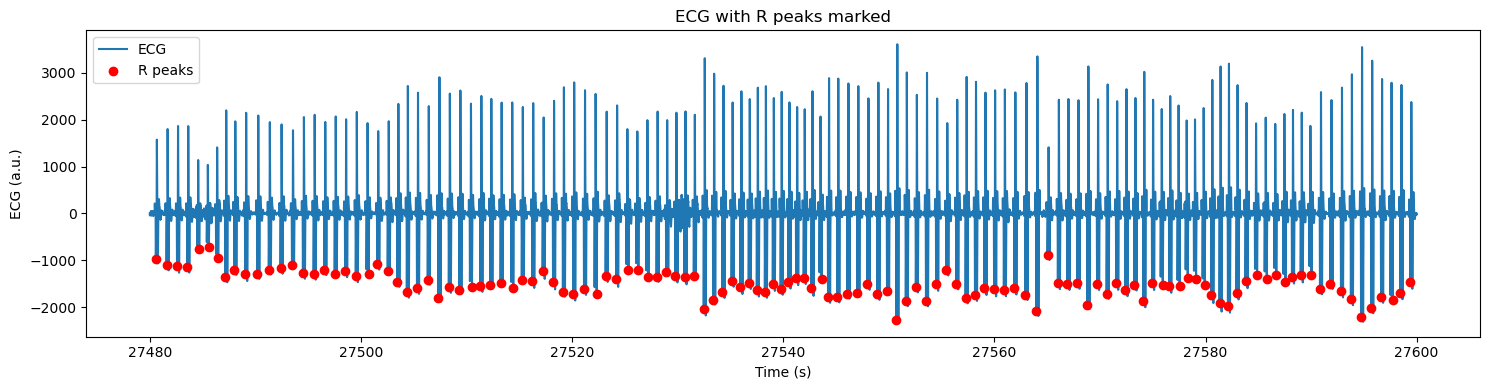

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(res["t_proc"], res["ecg_proc"], label="ECG")
plt.scatter(res["t_proc"][peaks], res["ecg_proc"][peaks], color='red', label="R peaks", zorder=3)
plt.xlabel("Time (s)")
plt.ylabel("ECG (a.u.)")
plt.title("ECG with R peaks marked")
plt.legend()
plt.tight_layout()
plt.show()

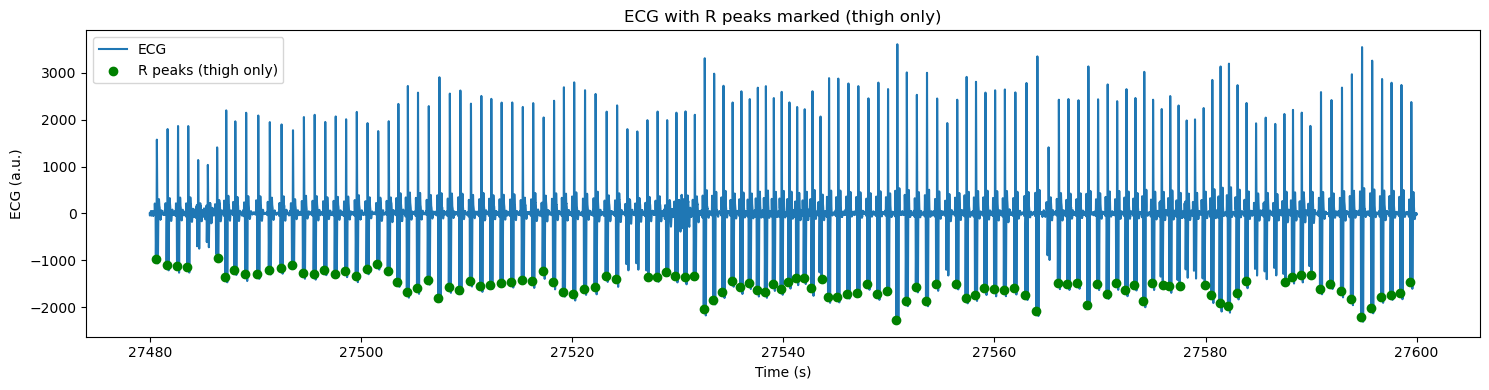

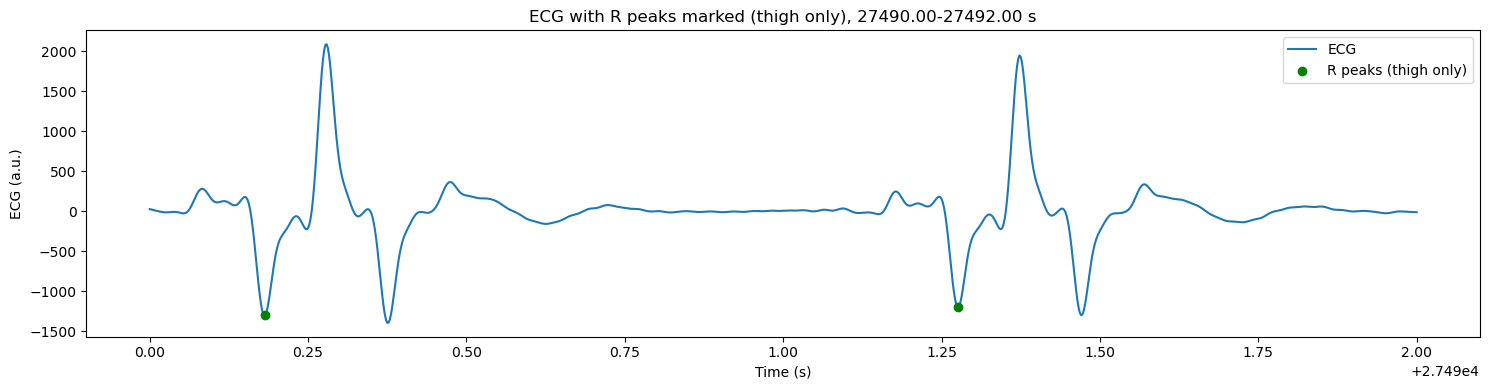

In [4]:
lv = jp.LabVIEWRpeak(jp.LVParams(fs=res["meta"]["fs_used"], enable_tlow=False))
peaks_thighonly = lv.detect(res["ecg_proc"])

plt.figure(figsize=(15, 4))
plt.plot(res["t_proc"], res["ecg_proc"], label="ECG")
plt.scatter(res["t_proc"][peaks_thighonly], res["ecg_proc"][peaks_thighonly], color='green', label="R peaks (thigh only)", zorder=3)
plt.xlabel("Time (s)")
plt.ylabel("ECG (a.u.)")
plt.title("ECG with R peaks marked (thigh only)")
plt.legend()
plt.tight_layout()
plt.show()

start_time = res["t_proc"][0] + 10  # e.g. start at 10s into the slice
end_time = start_time + 2           # 2 seconds window

mask = (res["t_proc"] >= start_time) & (res["t_proc"] <= end_time)

plt.figure(figsize=(15, 4))
plt.plot(res["t_proc"][mask], res["ecg_proc"][mask], label="ECG")
peaks_in_window = peaks_thighonly[(res["t_proc"][peaks_thighonly] >= start_time) & (res["t_proc"][peaks_thighonly] <= end_time)]
plt.scatter(res["t_proc"][peaks_in_window], res["ecg_proc"][peaks_in_window], color='green', label="R peaks (thigh only)", zorder=3)
plt.xlabel("Time (s)")
plt.ylabel("ECG (a.u.)")
plt.title(f"ECG with R peaks marked (thigh only), {start_time:.2f}-{end_time:.2f} s")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import importlib, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
import jeppesen_pipeline as jp
jp = importlib.reload(jp)

# TDMS_PATH  = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"
RUN_TAG    = "patient5_full"              # alt output præfiks
FS_OVERRIDE = 512.0                       # sæt None hvis TDMS indeholder timing


In [7]:
res = jp.run_pipeline_from_tdms_auto(
    tdms_path=TDMS_PATH,
    fs_override=FS_OVERRIDE,
    preproc="labview",
    ui_defaults=True,          # sætter 60/300 trim, 1–32 Hz, smooth=4
    # ingen start_s/dur_s => hele filen
    rpeak_mode="labview",      # LabVIEW-detektor m. auto-polaritet
    window_beats=100,
    auto_baseline_beats=20000, # baseline til automatisk thresholds (ca. ~40 min ved 70 bpm)
    auto_pct=99.5,
    plots=True,
    out=RUN_TAG
)

fs   = res["meta"]["fs_used"]
peaks = res["peaks"].astype(int)
print("Samples:", len(res["ecg_proc"]), "fs:", fs, "Peaks:", len(peaks))


Samples: 82275968 fs: 512.0 Peaks: 172834


In [8]:
# Peaks + RR
pd.DataFrame({
    "peak_sample": peaks,
    "peak_time_s": peaks/fs
}).to_csv(f"{RUN_TAG}_peaks.csv", index=False)

pd.DataFrame({
    "t_rr_s": res["t_rr"],
    "rr_s":   res["rr_sec"]
}).to_csv(f"{RUN_TAG}_rr.csv", index=False)

# Features + detektioner
res["features"].to_csv(f"{RUN_TAG}_features.csv", index=False)
res["detections"].to_csv(f"{RUN_TAG}_detections.csv", index=False)

# Meta
with open(f"{RUN_TAG}_meta.json", "w", encoding="utf-8") as f:
    json.dump(res["meta"], f, indent=2, default=str)


In [9]:
sig = res["ecg_proc"]
dec = max(1, int(fs//64))           # reducer til ~64 Hz for oversigtsplot
sig_ds = sig[::dec]; t_ds = np.arange(len(sig_ds))*(dec/fs)
peaks_ds_mask = (peaks % dec)==0
plt.figure(figsize=(12,3))
plt.plot(t_ds, sig_ds, lw=0.4)
plt.plot(peaks[peaks_ds_mask]/fs, sig[(peaks[peaks_ds_mask])], "o", ms=2)
plt.title("ECG overview (downsampled) + peaks"); plt.xlabel("s")
plt.tight_layout(); plt.savefig(f"{RUN_TAG}_overview.png", dpi=160); plt.close()


In [10]:
import numpy as np
import pandas as pd

def load_labview_lvm_rr(path):
    """
    Læser en LabVIEW LVM-tekstfil som den du viser (tab-sep, decimalkomma).
    Returnerer:
      rr_sec         : np.ndarray, RR-intervaller i sekunder
      t_rr_s         : np.ndarray, sluttid for hvert RR (kumulativ sum)
      peaks_time_s   : np.ndarray, peak-tider (sek) relativt til start (0 for første peak før første RR)
      df_raw         : pd.DataFrame med rå kolonner
    """
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    # Data starter efter den ANDEN ***End_of_Header***
    parts = txt.split("***End_of_Header***")
    if len(parts) < 2:
        raise ValueError("Kunne ikke finde ***End_of_Header*** to gange i LVM-filen.")
    data_part = parts[2] if len(parts) >= 3 else parts[1]  # nogle LVM har to headerblokke

    # Rens og split linjer
    lines = [ln for ln in data_part.strip().splitlines() if ln.strip()]
    # Første linje i data-delen er kolonneheader (fx "X_Value\tUntitled\tComment")
    # Resten er data
    # Håndtér decimalkomma og tabs
    def to_float(s):
        s = s.strip().replace(",", ".")
        return float(s)

    # Find header
    header = [h.strip() for h in lines[0].split("\t")]
    # læs kolonner (tag de to første tal-kolonner)
    vals = []
    for ln in lines[1:]:
        cols = ln.split("\t")
        if len(cols) < 2:
            continue
        try:
            x_val = to_float(cols[0])
            rrval = to_float(cols[1])
            vals.append((x_val, rrval))
        except ValueError:
            # spring fx tom/kommentar-linjer over
            continue

    if not vals:
        raise ValueError("Ingen gyldige data-rækker fundet i LVM-filen.")

    arr = np.array(vals, dtype=float)
    x_value = arr[:,0]                 # tæller (0,1,2,...)
    rr_sec  = arr[:,1]                 # RR i sekunder (tid siden sidste peak)
    t_rr_s  = np.cumsum(rr_sec)        # sluttidspunkter for hvert RR
    # Peak-tider (sek): antag at der var et peak ved tid 0, og derefter efter hvert RR
    # Dvs. peaks ved [0, rr1, rr1+rr2, ...]
    peaks_time_s = np.concatenate(([0.0], t_rr_s))

    df_raw = pd.DataFrame({"X_Value": x_value, "RR_s": rr_sec})
    return rr_sec, t_rr_s, peaks_time_s, df_raw


In [11]:
# LVM_PATH = r"C:\Users\kvjkv\Downloads\Patient2-results.lvm"   # <-- din LabVIEW-eksport
rr_lv, t_rr_lv, peaks_lv_s, df_lv = load_labview_lvm_rr(LVM_PATH)
print(len(rr_lv), "RR;  sidste peak ved", peaks_lv_s[-1], "s")
df_lv.head()


186435 RR;  sidste peak ved 321731.2838349995 s


,X_Value,RR_s
0,0.0,1.862693
1,1.0,1.624412
2,2.0,1.073804
3,3.0,0.265930
4,4.0,2.175366


In [12]:
import importlib, jeppesen_pipeline as jp
jp = importlib.reload(jp)

RUN_TAG   = "patient5_full"

res = jp.run_pipeline_from_tdms_auto(
    tdms_path=TDMS_PATH,
    fs_override=512.0,
    preproc="labview", ui_defaults=True,   # 60s/300s trim, 1–32 Hz, smooth=4
    rpeak_mode="labview",
    window_beats=100,
    auto_baseline_beats=20000,
    auto_pct=99.5,
    plots=True, out=RUN_TAG
)

fs = res["meta"]["fs_used"]
peaks_py_s = res["peaks"] / fs  # peak-tider i sekunder


In [13]:
import numpy as np

def match_peaks_times(t_ref, t_test, tol_s=0.08):
    """Greedy match test->ref. Returnerer tp, fp, fn og match-liste."""
    i, j = 0, 0
    tp = 0; matched_ref = np.zeros(len(t_ref), dtype=bool)
    matches = []
    while i < len(t_test) and j < len(t_ref):
        dt = t_test[i] - t_ref[j]
        if abs(dt) <= tol_s:
            if not matched_ref[j]:
                tp += 1; matched_ref[j] = True
                matches.append((i, j, dt))
            i += 1; j += 1
        elif dt > tol_s:
            j += 1
        else:
            i += 1
    fp = len(t_test) - tp
    fn = len(t_ref) - matched_ref.sum()
    return tp, fp, fn, matches

def best_constant_offset(t_ref, t_test, tol_s=0.08, search_range_s=120.0, step_s=0.02):
    offs = np.arange(-search_range_s, search_range_s+step_s/2, step_s)
    best = None
    for off in offs:
        tp, fp, fn, _ = match_peaks_times(t_ref, t_test + off, tol_s)
        # max TP, tiebreak: max F1
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
        score = (tp, f1)
        if best is None or score > best[0]:
            best = (score, off, (tp, fp, fn))
    (_, _f1), off_star, (tp, fp, fn) = best
    return off_star, tp, fp, fn

# 1) Indlæs LabVIEW
# LVM_PATH = r"C:\Users\kvjkv\Downloads\Patient2-results.lvm"
rr_lv, t_rr_lv, peaks_lv_s, df_lv = load_labview_lvm_rr(LVM_PATH)

# 2) Find bedste offset (hvis nødvendigt)
off, tp, fp, fn = best_constant_offset(peaks_lv_s, peaks_py_s, tol_s=0.08, search_range_s=180.0, step_s=0.02)
prec = tp/(tp+fp) if (tp+fp)>0 else np.nan
rec  = tp/(tp+fn) if (tp+fn)>0 else np.nan
f1   = 2*prec*rec/(prec+rec) if np.isfinite(prec) and np.isfinite(rec) else np.nan

print(f"Bedste offset: {off:+.2f} s | TP={tp}  FP={fp}  FN={fn} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")

# 3) Gem match-detaljer (valgfrit)
tp2, fp2, fn2, matches = match_peaks_times(peaks_lv_s, peaks_py_s + off, tol_s=0.08)
import pandas as pd
pd.DataFrame(matches, columns=["py_idx","lv_idx","delta_s"]).to_csv(f"{RUN_TAG}_matches.csv", index=False)


Bedste offset: +60.34 s | TP=17234  FP=155600  FN=169202 | P=0.100 R=0.092 F1=0.096


In [21]:
# LabVIEW peaks i samples (brug samme fs som i Python-resultatet)
peaks_lv_samples = np.round(peaks_lv_s * fs).astype(int)
peaks_py_samples = res["peaks"].astype(int)

# Så kan du matche i sampledomænet med tol_samples = round(0.08*fs)


In [22]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def load_labview_lvm_rr(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    parts = txt.split("***End_of_Header***")
    if len(parts) < 2:
        raise ValueError("Kunne ikke finde ***End_of_Header*** 2 gange.")
    data_part = parts[2] if len(parts) >= 3 else parts[1]
    lines = [ln for ln in data_part.strip().splitlines() if ln.strip()]
    def to_f(s): return float(s.strip().replace(",", "."))
    vals = []
    for ln in lines[1:]:
        cols = ln.split("\t")
        if len(cols) < 2: continue
        try:
            x_val = to_f(cols[0])  # ikke brugt
            rr    = to_f(cols[1])
            vals.append(rr)
        except: pass
    rr = np.array(vals, float)
    t_rr = np.cumsum(rr)
    peaks_s = np.concatenate(([0.0], t_rr))
    return rr, t_rr, peaks_s

def match_peaks_times(t_ref, t_test, tol_s=0.08):
    i=j=0; tp=0; matched = np.zeros(len(t_ref), bool); matches=[]
    while i<len(t_test) and j<len(t_ref):
        dt = t_test[i]-t_ref[j]
        if abs(dt)<=tol_s:
            if not matched[j]:
                tp+=1; matched[j]=True; matches.append((i,j,dt))
            i+=1; j+=1
        elif dt>tol_s: j+=1
        else: i+=1
    fp = len(t_test)-tp; fn = len(t_ref)-matched.sum()
    P = tp/(tp+fp) if (tp+fp)>0 else np.nan
    R = tp/(tp+fn) if (tp+fn)>0 else np.nan
    F1= 2*P*R/(P+R) if np.isfinite(P) and np.isfinite(R) and (P+R)>0 else np.nan
    return tp, fp, fn, P, R, F1, matches


In [23]:
import importlib, jeppesen_pipeline as jp
jp = importlib.reload(jp)

def butter_1_32(x, fs, order=4):
    from scipy.signal import butter, filtfilt
    ny = fs/2; b,a = butter(order, [1.0/ny, 32.0/ny], btype="band")
    return filtfilt(b,a,x)

def downsample_to_256(x, fs):
    if abs(fs-256.0)<1e-9: return x, fs
    from scipy.signal import resample_poly
    up=1; down=int(round(fs/256.0))
    y = resample_poly(x, up, down)
    return y, 256.0

def detect_thigh_only(ecg_proc, fs, per_window=True):
    """Thigh-only (tlow OFF), per-window polaritet (2 s), radius/DELTA @256Hz med ev. nedskalering håndteres i LVParams."""
    # Lav LVParams; slå Tlow fra:
    p = jp.LVParams(fs=fs, auto_polarity=("per_window" if per_window else "global16s"), enable_tlow=False)
    # Hvis din LVParams ikke har auto_polarity/enable_tlow, kan vi falde tilbage:
    if "auto_polarity" not in getattr(jp.LVParams, "__annotations__", {}):
        # fallback fra før:
        peaks, xpol = jp._detect_labview_with_autopol_fallback(ecg_proc, fs, auto_polarity=("per_window" if per_window else "global16s"))
        # Tving Tlow fra ved at køre Thigh-kryds på xpol:
        bp = xpol  # ecg_proc er allerede båndpasset/smoothed; brug direkte
        # Thigh konstruktion
        L = int(round(2.0*fs)); rect = np.maximum(bp,0.0)
        wmax=[]; edges=[]
        for st in range(0,len(rect),L):
            en=min(len(rect),st+L); wmax.append(np.max(rect[st:en]) if en>st else 0.0); edges.append((st,en))
        wmax=np.array(wmax); thigh_w=np.zeros_like(wmax)
        for k in range(len(wmax)):
            thigh_w[k] = 0.75*(np.median(wmax[max(0,k-8):k]) if k>0 else wmax[0])
        thigh=np.zeros(len(bp))
        for k,(st,en) in enumerate(edges): thigh[st:en]=thigh_w[k]
        # kryds + lokaliser
        radius = int(round(15*(fs/256.0)))
        cand = np.where((bp[1:]>thigh[1:]) & (bp[:-1]<=thigh[:-1]))[0]+1
        peaks=[]
        for i in cand:
            st=max(0,i-radius); en=min(len(bp), i+radius+1)
            idx=st+np.argmax(bp[st:en])
            if not peaks or idx-peaks[-1] >= int(round(0.25*fs)):
                peaks.append(idx)
        return np.array(peaks,int), xpol
    # “rigtig” vej hvis din LVParams/LabVIEWRpeak er opdateret:
    lv = jp.LabVIEWRpeak(p)
    peaks = lv.detect(ecg_proc)
    return peaks, ecg_proc  # pol sker inde i detect

def run_variant(tdms_path, fs_override, variant="A", out_tag="runA"):
    # 1) læs TDMS
    x, t_sec, fs, *_ = jp.read_tdms_auto(tdms_path, fs_override=fs_override)

    # 2) præproc
    if variant in ("A","B"):
        # Butterworth 1–32 + 4-samples smoothing
        xp = butter_1_32(x, fs)
        xp = np.convolve(xp, np.ones(4)/4.0, mode="same")
    else:
        # Equi-ripple (modulets labview-preproc) uden trim
        xp, _ = jp._preprocess_labview_bandpass(x, fs, delete_start_s=0.0, delete_end_s=0.0,
                                                hp_stop=1.0, hp_pass=1.2, lp_pass=32.0, lp_stop=50.0, smooth_win_samples=4)

    # 3) evt. ned til 256 Hz
    if variant in ("B","D"):
        xp, fs_use = downsample_to_256(xp, fs)
    else:
        fs_use = fs

    # 4) detektion: Thigh-only + per-vindue polaritet
    peaks, xpol = detect_thigh_only(xp, fs_use, per_window=True)

    return {"peaks":peaks, "fs":fs_use, "ecg":xp, "ecg_pol":xpol}


In [24]:
FS_OVERRIDE = 512.0

rr_lv, t_rr_lv, peaks_lv_s = load_labview_lvm_rr(LVM_PATH)

results = []
for variant in ["A","B","C","D"]:
    print("Kører", variant, "…")
    out = run_variant(TDMS_PATH, FS_OVERRIDE, variant=variant, out_tag=f"full_{variant}")
    fs = out["fs"]; peaks_py_s = out["peaks"]/fs
    tp,fp,fn,P,R,F1,_ = match_peaks_times(peaks_lv_s, peaks_py_s, tol_s=0.08)
    results.append({"variant":variant, "TP":tp, "FP":fp, "FN":fn, "P":P, "R":R, "F1":F1, "fs":fs, "n_peaks_py":len(out["peaks"])})
    print(f"{variant}: P={P:.3f} R={R:.3f} F1={F1:.3f} | n_py={len(out['peaks'])}")

pd.DataFrame(results)


Kører A …
A: P=0.132 R=0.131 F1=0.132 | n_py=91061
Kører B …
B: P=0.132 R=0.132 F1=0.132 | n_py=91919
Kører C …
C: P=0.133 R=0.129 F1=0.131 | n_py=89101
Kører D …
D: P=0.132 R=0.130 F1=0.131 | n_py=89570


,variant,TP,FP,FN,P,R,F1,fs,n_peaks_py
0,A,12009,79052,79561,0.131879,0.131146,0.131511,512.0,91061
1,B,12132,79787,79438,0.131986,0.132489,0.132237,256.0,91919
2,C,11806,77295,79764,0.132501,0.128929,0.130691,512.0,89101
3,D,11860,77710,79710,0.132410,0.129518,0.130948,256.0,89570


Hvis A > C, var remez-kæden problemet → vi fastholder Butterworth.

Hvis B > A, hjælper 256 Hz → vi kører hele detektoren på 256 Hz.

Hvis Thigh-only giver pæn P/R, tænder vi Tlow igen mildt bagefter.

In [25]:
def per_minute_scores(peaks_s, lv_s, duration_s, tol=0.08, step=60.0):
    bins = np.arange(0, duration_s+step, step)
    recs=[]
    for k in range(len(bins)-1):
        a,b = bins[k], bins[k+1]
        p  = peaks_s[(peaks_s>=a)&(peaks_s<b)]
        lv = lv_s[(lv_s>=a)&(lv_s<b)]
        tp,fp,fn,P,R,F1,_ = match_peaks_times(lv, p, tol)
        recs.append({"min":k, "start_s":a, "P":P, "R":R, "F1":F1, "n_py":len(p), "n_lv":len(lv)})
    return pd.DataFrame(recs)

# vælg bedste variant (fx den med højest F1)
best = max(results, key=lambda r: (r["F1"], r["P"]))
best_out = run_variant(TDMS_PATH, FS_OVERRIDE, variant=best["variant"], out_tag="best")
dur = len(best_out["ecg"])/best_out["fs"]
df_min = per_minute_scores(best_out["peaks"]/best_out["fs"], peaks_lv_s, dur, tol=0.08)
df_min.head()


,min,start_s,P,R,F1,n_py,n_lv
0,0,0.0,0.183673,0.166667,0.174757,49,54
1,1,60.0,0.173913,0.235294,0.200000,69,51
2,2,120.0,0.111111,0.196078,0.141844,90,51
3,3,180.0,0.110000,0.207547,0.143791,100,53
4,4,240.0,0.177215,0.241379,0.204380,79,58


In [29]:
import importlib, numpy as np, pandas as pd, matplotlib.pyplot as plt
import jeppesen_pipeline as jp
jp = importlib.reload(jp)

# --- Preproc: Butterworth 1–32 + smoothing (som i variant B) ---
from scipy.signal import butter, filtfilt, resample_poly
def butter_1_32(x, fs, order=4):
    ny = fs/2; b,a = butter(order, [1.0/ny, 32.0/ny], btype="band")
    return filtfilt(b,a,x)

def preproc_butter_256(x, fs):
    x = butter_1_32(x, fs)
    x = np.convolve(x, np.ones(4)/4.0, mode="same")
    if abs(fs-256.0) > 1e-9:
        x = resample_poly(x, 1, int(round(fs/256.0)))
        fs = 256.0
    return x, fs

# --- Læs hele TDMS og preproc ---
FS_OVERRIDE = 512.0  # eller None hvis din TDMS har korrekt sampling

x, t_sec, fs, *_ = jp.read_tdms_auto(TDMS_PATH, fs_override=FS_OVERRIDE)
x_bp, fs2 = preproc_butter_256(x, fs)

# --- LabVIEW-detektor med Tlow = ON (mild) ---
# Brug din rene klasse; hvis ikke patchet, holder vi Thigh-only (som fallback)
use_new = "auto_polarity" in getattr(jp.LVParams, "__annotations__", {}) and \
          "enable_tlow"   in getattr(jp.LVParams, "__annotations__", {})

if use_new:
    lv = jp.LabVIEWRpeak(jp.LVParams(
        fs=fs2,
        auto_polarity="per_window",   # vigtig
        enable_tlow=True              # tænd Tlow igen
    ))
    peaks_py = lv.detect(x_bp)
else:
    # fallback: Thigh-only. (Hvis du vil kan vi efterligne Tlow mild her også)
    peaks_py, _ = jp._detect_labview_with_autopol_fallback(x_bp, fs2, auto_polarity="per_window")

peaks_py_s = peaks_py / fs2

# --- Indlæs LVM RR/peaks ---
def load_labview_lvm_rr(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    parts = txt.split("***End_of_Header***")
    data_part = parts[2] if len(parts)>=3 else parts[1]
    lines = [ln for ln in data_part.strip().splitlines() if ln.strip()]
    def to_f(s): return float(s.strip().replace(",", "."))
    vals=[]
    for ln in lines[1:]:
        cols = ln.split("\t")
        if len(cols) < 2: continue
        try: vals.append(to_f(cols[1]))
        except: pass
    rr = np.array(vals, float); t_rr = np.cumsum(rr); peaks_s = np.concatenate(([0.0], t_rr))
    return rr, t_rr, peaks_s

rr_lv, t_rr_lv, peaks_lv_s = load_labview_lvm_rr(LVM_PATH)

# --- Match (±80 ms) + bedste offset (hvis du vil se konstant forskydning) ---
def match_peaks_times(t_ref, t_test, tol_s=0.08):
    i=j=0; tp=0; matched=np.zeros(len(t_ref), bool)
    while i<len(t_test) and j<len(t_ref):
        dt = t_test[i]-t_ref[j]
        if abs(dt)<=tol_s:
            if not matched[j]: tp += 1; matched[j] = True
            i+=1; j+=1
        elif dt>tol_s: j+=1
        else: i+=1
    fp=len(t_test)-tp; fn=len(t_ref)-matched.sum()
    P = tp/(tp+fp) if (tp+fp)>0 else np.nan
    R = tp/(tp+fn) if (tp+fn)>0 else np.nan
    F1= 2*P*R/(P+R) if np.isfinite(P) and np.isfinite(R) and (P+R)>0 else np.nan
    return tp,fp,fn,P,R,F1

tp,fp,fn,P,R,F1 = match_peaks_times(peaks_lv_s, peaks_py_s, tol_s=0.08)
print(f"B + Tlow(ON,mild): TP={tp} FP={fp} FN={fn} | P={P:.3f} R={R:.3f} F1={F1:.3f}  fs={fs2}")


B + Tlow(ON,mild): TP=16023 FP=106211 FN=75547 | P=0.131 R=0.175 F1=0.150  fs=256.0


In [30]:
def match_stats_in_window(t_ref, t_test, a, b, tol=0.08):
    r = t_ref[(t_ref>=a)&(t_ref<b)]
    t = t_test[(t_test>=a)&(t_test<b)]
    return match_peaks_times(r, t, tol)

def per_minute_scores(peaks_py_s, peaks_lv_s, duration_s, tol=0.08, step=60.0):
    bins = np.arange(0, duration_s+step, step)
    rows=[]
    for k in range(len(bins)-1):
        a,b = bins[k], bins[k+1]
        tp,fp,fn,P,R,F1 = match_stats_in_window(peaks_lv_s, peaks_py_s, a, b, tol)
        rows.append({"min":k, "start_s":a, "P":P, "R":R, "F1":F1})
    return pd.DataFrame(rows)

dur = len(x_bp)/fs2
df_min = per_minute_scores(peaks_py_s, peaks_lv_s, dur, tol=0.08, step=60.0).fillna(0.0)
bad = df_min.sort_values("F1").head(8)   # 8 værste minutter
bad


,min,start_s,P,R,F1
8,8,480.0,0.028571,0.057692,0.038217
506,506,30360.0,0.033333,0.066667,0.044444
1050,1050,63000.0,0.032967,0.081081,0.046875
323,323,19380.0,0.039604,0.076923,0.052288
1040,1040,62400.0,0.042254,0.073171,0.053571
496,496,29760.0,0.048544,0.100000,0.065359
1036,1036,62160.0,0.054795,0.100000,0.070796
981,981,58860.0,0.050360,0.159091,0.076503


In [34]:
def plot_zoom(ecg, fs, peaks_s, t0, title, fname):
    t = np.arange(len(ecg))/fs
    m = (peaks_s>=t0) & (peaks_s<t0+10)
    ps = peaks_s[m]
    plt.figure(figsize=(10,3))
    plt.plot(t, ecg, lw=0.6)
    plt.plot(ps, ecg[(ps*fs).astype(int)], "o", ms=3)
    plt.xlim(t0, t0+10)
    plt.ylim(-700, 1000)  # Fixed y-axis limits
    plt.title(title)
    plt.xlabel("s")
    plt.tight_layout()
    plt.savefig(fname, dpi=160)
    plt.close()

import os
os.makedirs("qa_plots", exist_ok=True)
for _,row in bad.iterrows():
    start = float(row["start_s"])
    z0 = start + 25.0
    plot_zoom(x_bp, fs2, peaks_py_s, z0,
              f"Worst min {int(row['min'])} (F1={row['F1']:.2f})",
              f"qa_plots/min_{int(row['min'])}_zoom.png")


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_7728\406773820.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\kvjkv\anaconda3\envs\kvj\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


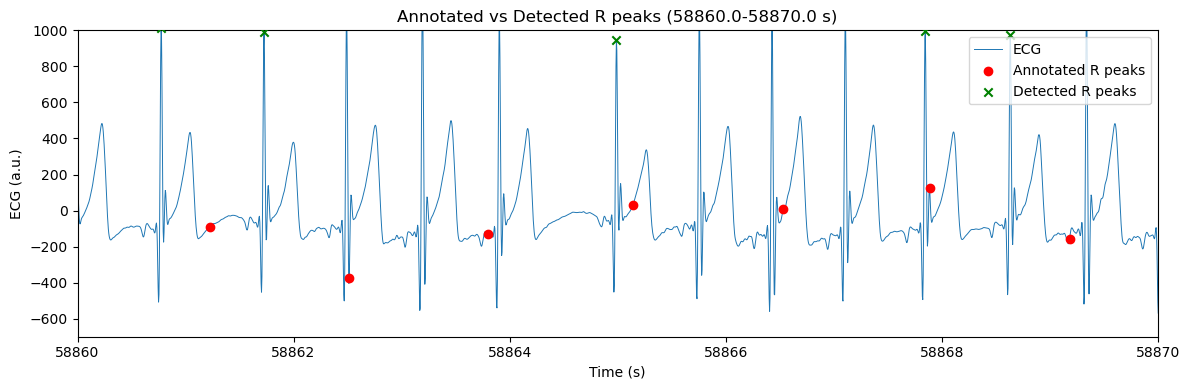

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(t, ecg, label="ECG", lw=0.7)
plt.scatter(annot_peaks, ecg[(annot_peaks * fs_plot).astype(int)], color='red', label="Annotated R peaks", zorder=3)
plt.scatter(detected_peaks, ecg[(detected_peaks * fs_plot).astype(int)], color='green', label="Detected R peaks", zorder=3, marker='x')
plt.xlim(window_start, window_end)
plt.ylim(-700, 1000)  # Fixed y-axis limits as before
plt.xlabel("Time (s)")
plt.ylabel("ECG (a.u.)")
plt.title(f"Annotated vs Detected R peaks ({window_start:.1f}-{window_end:.1f} s)")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
import numpy as np, pandas as pd

# ---- 1) Læs LVM RR og konverter til PEAK SAMPLES uden float-drift ----
def load_labview_lvm_rr(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    parts = txt.split("***End_of_Header***")
    data_part = parts[2] if len(parts)>=3 else parts[1]
    lines = [ln for ln in data_part.strip().splitlines() if ln.strip()]
    def to_f(s): return float(s.strip().replace(",", "."))
    rr = []
    for ln in lines[1:]:
        cols = ln.split("\t")
        if len(cols) >= 2:
            try: rr.append(to_f(cols[1]))
            except: pass
    rr = np.array(rr, float)
    return rr

def rr_to_peak_samples(rr_sec, fs_lv):
    # konverter RR til heltal-samples (runde hver RR, og kumulér i int)
    rr_samp = np.round(rr_sec * fs_lv).astype(int)
    peaks = np.concatenate(([0], np.cumsum(rr_samp)))  # første peak ved 0
    return peaks, rr_samp

# ---- 2) Match i samples (greedy) med tolerance i samples ----
def match_samples(ref_idx, test_idx, tol_samp=3):
    i=j=0; tp=0; matched = np.zeros(len(ref_idx), bool)
    while i<len(test_idx) and j<len(ref_idx):
        d = test_idx[i] - ref_idx[j]
        if abs(d) <= tol_samp:
            if not matched[j]:
                tp += 1; matched[j] = True
            i+=1; j+=1
        elif d > tol_samp:
            j+=1
        else:
            i+=1
    fp = len(test_idx) - tp
    fn = len(ref_idx) - matched.sum()
    P = tp/(tp+fp) if (tp+fp)>0 else np.nan
    R = tp/(tp+fn) if (tp+fn)>0 else np.nan
    F1 = 2*P*R/(P+R) if np.isfinite(P) and np.isfinite(R) and (P+R)>0 else np.nan
    return P,R,F1,tp,fp,fn

# ---- 3) Kør: lav LV peaks @256 og @512 og match mod Python peaks ----
rr_lv = load_labview_lvm_rr(LVM_PATH)

# Python peaks/sampling fra din fuldkørsel:
import jeppesen_pipeline as jp, importlib
jp = importlib.reload(jp)
# her antager vi du allerede har kørt run_pipeline_from_tdms_auto(...)
# ellers kør den og hent:
# res = jp.run_pipeline_from_tdms_auto(...)
peaks_py = res["peaks"].astype(int)
fs_py    = int(round(res["meta"]["fs_used"]))

for fs_guess in (256, 512):
    lv_peaks_samp, rr_samp = rr_to_peak_samples(rr_lv, fs_guess)
    # hvis der var 60s trim i Python men ikke i LV, justér: lv_peaks_samp -= int(60*fs_guess)
    # og smid negative fra:
    # lv_peaks_samp = lv_peaks_samp[lv_peaks_samp >= 0]

    # hvis fs ikke matcher, resampl Python peak-index til fs_guess:
    if fs_py != fs_guess:
        # skaler samples (rund af), så begge er i fs_guess
        peaks_py_fs_guess = np.round(peaks_py * (fs_guess / fs_py)).astype(int)
    else:
        peaks_py_fs_guess = peaks_py

    for tol in (3,5):
        P,R,F1,TP,FP,FN = match_samples(lv_peaks_samp, peaks_py_fs_guess, tol_samp=tol)
        print(f"LV@{fs_guess}Hz tol=±{tol} samp → P={P:.3f} R={R:.3f} F1={F1:.3f} | TP={TP} FP={FP} FN={FN}")


LV@256Hz tol=±3 samp → P=0.023 R=0.032 F1=0.027 | TP=2904 FP=124187 FN=88666
LV@256Hz tol=±5 samp → P=0.036 R=0.051 F1=0.042 | TP=4631 FP=122460 FN=86939
LV@512Hz tol=±3 samp → P=0.012 R=0.016 F1=0.013 | TP=1466 FP=125625 FN=90104
LV@512Hz tol=±5 samp → P=0.018 R=0.025 F1=0.021 | TP=2269 FP=124822 FN=89301


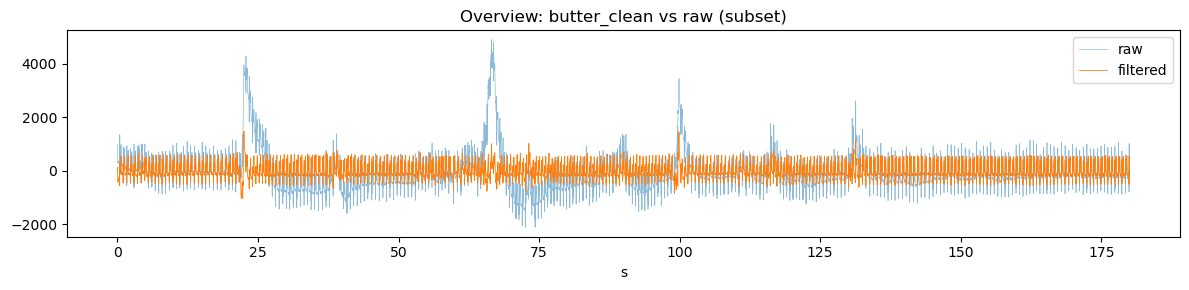

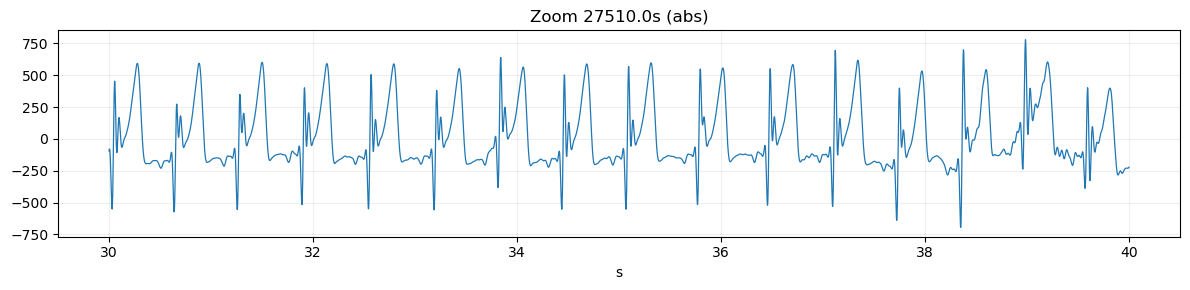

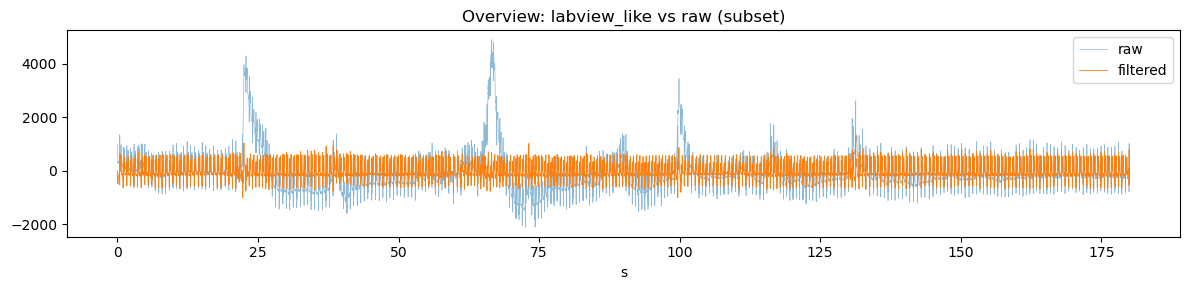

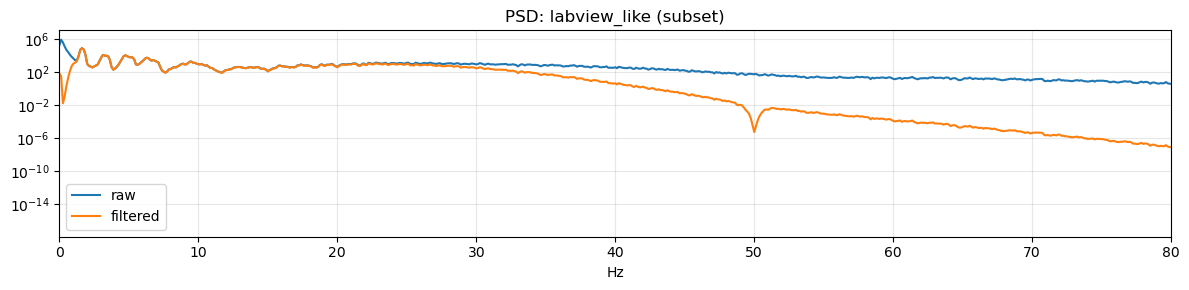

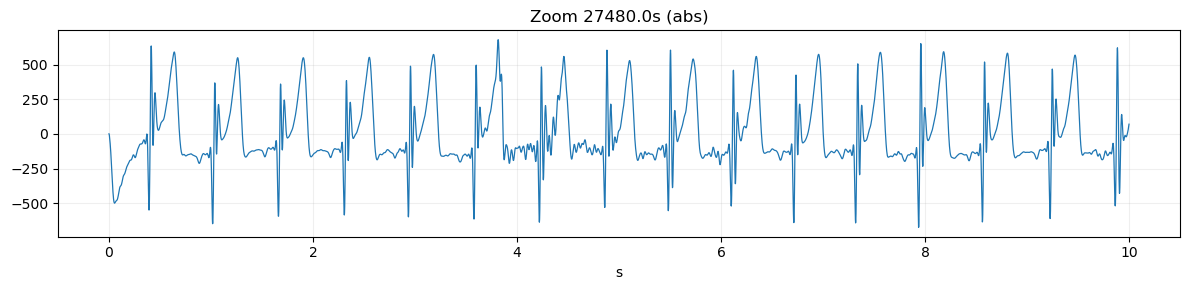

In [41]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, sosfreqz, resample_poly, welch, savgol_filter

# ---------- hjælpere ----------
def highpass(x, fs, fc=0.5, order=2):
    sos = butter(order, fc/(fs/2), btype="highpass", output="sos")
    return sosfiltfilt(sos, x)

def lowpass(x, fs, fc=25.0, order=4):
    sos = butter(order, fc/(fs/2), btype="lowpass", output="sos")
    return sosfiltfilt(sos, x)

def bandpass(x, fs, f1=1.0, f2=32.0, order=4):
    sos = butter(order, [f1/(fs/2), f2/(fs/2)], btype="bandpass", output="sos")
    return sosfiltfilt(sos, x)

def notch_series(x, fs, f0=50.0, n_harm=3, Q=35):
    y = x.copy()
    for k in range(1, n_harm+1):
        fk = f0*k
        if fk >= fs/2-0.5: break
        b,a = iirnotch(w0=fk/(fs/2), Q=Q)
        y = filtfilt(b,a,y)
    return y

def moving_average(x, n=4):
    if n<=1: return x
    k = np.ones(n)/float(n)
    return np.convolve(x, k, mode="same")

def robust_center(x, pct=1.0):
    # fjern grov offset, men bevar morfologi
    med = np.median(x)
    return x - med

def psd(x, fs, nperseg=4096):
    f, Pxx = welch(x, fs=fs, nperseg=min(nperseg, len(x)))
    return f, Pxx

def plot_overview(raw, filt, fs, title=""):
    t = np.arange(len(raw))/fs
    dec = max(1, int(fs//128))  # tyndt plot
    plt.figure(figsize=(12,3))
    plt.plot(t[::dec], raw[::dec], lw=0.5, alpha=0.5, label="raw")
    plt.plot(t[::dec], filt[::dec], lw=0.6, label="filtered")
    plt.legend(); plt.title(title); plt.xlabel("s"); plt.tight_layout(); plt.show()

def plot_psd(raw, filt, fs, title="PSD"):
    f1,P1 = psd(raw, fs); f2,P2 = psd(filt, fs)
    plt.figure(figsize=(12,3))
    plt.semilogy(f1,P1, label="raw")
    plt.semilogy(f2,P2, label="filtered")
    plt.xlim(0, 80); plt.grid(True, alpha=0.3); plt.legend()
    plt.title(title); plt.xlabel("Hz"); plt.tight_layout(); plt.show()

def plot_zoom_abs(sig, fs, abs_start_s, window_s, subset_start_s):
    """sig is already a subset starting at subset_start_s (absolute seconds)."""
    t0_rel = abs_start_s - subset_start_s
    plot_zoom(sig, fs, t0=max(0.0, t0_rel), dur=window_s,
              title=f"Zoom {abs_start_s:.1f}s (abs)")

# ---------- 2 præprocesseringsprofiler ----------
def preproc_butter_clean(x, fs, mains=50, mains_harm=3,
                         hp_fc=0.5, lp_fc=25.0, smooth_ms=8):
    """
    Robust 'klinisk' profil:
      1) robust center (median)
      2) notch 50/60 Hz + harmoniske
      3) highpass 0.5 Hz (baseline)
      4) lowpass 25 Hz (T-wave dæmpning)
      5) let smoothing (Savitzky-Golay el. moving avg)
    """
    y = robust_center(x)
    y = notch_series(y, fs, f0=mains, n_harm=mains_harm, Q=35)
    y = highpass(y, fs, fc=hp_fc, order=2)
    y = lowpass(y, fs, fc=lp_fc, order=4)
    # smoothing: ca. 8 ms vindue (min. 5 og ulige)
    win = max(5, int(round(smooth_ms*1e-3*fs))//2*2+1)
    if win < 7:  # fallback på 4-punkts MA ved meget høj fs
        y = moving_average(y, n=4)
    else:
        y = savgol_filter(y, window_length=win, polyorder=2, mode="interp")
    return y

def preproc_labview_like(x, fs, mains=50, mains_harm=3,
                         bp_lo=1.0, bp_hi=32.0, smooth_n=4):
    """
    Tæt på VI:
      1) robust center
      2) notch 50/60 Hz + harmoniske
      3) bandpass 1–32 Hz
      4) 4-samples glidende middel
    """
    y = robust_center(x)
    y = notch_series(y, fs, f0=mains, n_harm=mains_harm, Q=35)
    y = bandpass(y, fs, f1=bp_lo, f2=bp_hi, order=4)
    y = moving_average(y, n=smooth_n)
    return y

# ---------- læs din TDMS ----------
import importlib, jeppesen_pipeline as jp
jp = importlib.reload(jp)

TDMS_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"
FS_OVERRIDE = 512.0  # sæt None hvis din TDMS har korrekt fs

x, t_sec, fs, *_ = jp.read_tdms_auto(TDMS_PATH, fs_override=FS_OVERRIDE)

# vælg et arbejdsudsnit til hurtig iteration (kan sættes til hele signalet)
START_S, DUR_S = 7*3600+38*60, 180.0  # fx fra 07:38:00 i 3 minutter
i0, i1 = int(START_S*fs), int((START_S+DUR_S)*fs)
xw = x[i0:i1]

# ---------- kør profiler ----------
y1 = preproc_butter_clean(xw, fs, mains=50, mains_harm=3, hp_fc=0.5, lp_fc=25.0, smooth_ms=8)
y2 = preproc_labview_like(xw, fs, mains=50, mains_harm=3, bp_lo=1.0, bp_hi=32.0, smooth_n=4)

# ---------- plots ----------
plot_overview(xw, y1, fs, title="Overview: butter_clean vs raw (subset)")
# then call:
plot_zoom_abs(y1, fs, abs_start_s=START_S+30, window_s=10, subset_start_s=START_S)


plot_overview(xw, y2, fs, title="Overview: labview_like vs raw (subset)")
plot_psd(xw, y2, fs, title="PSD: labview_like (subset)")
plot_zoom_abs(y2, fs, abs_start_s=START_S, window_s=10, subset_start_s=START_S)


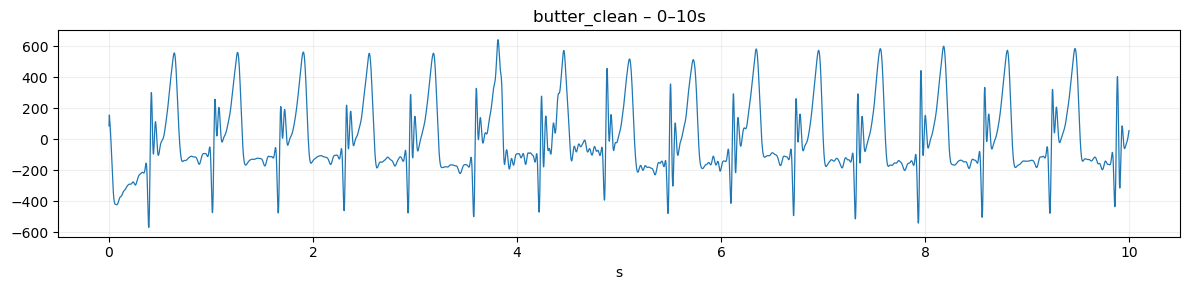

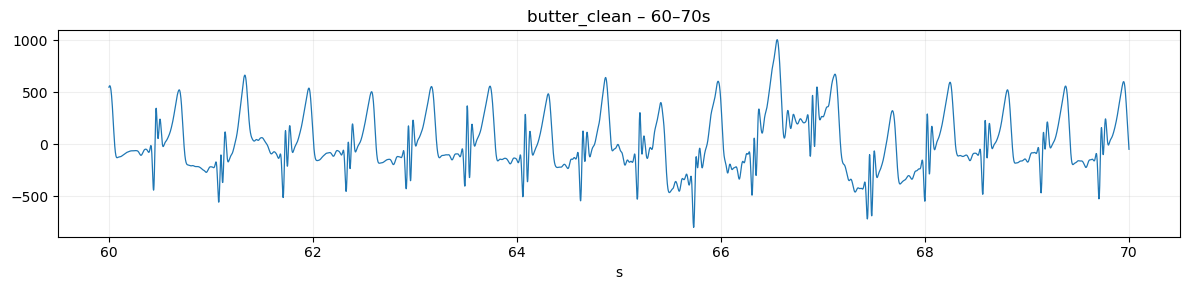

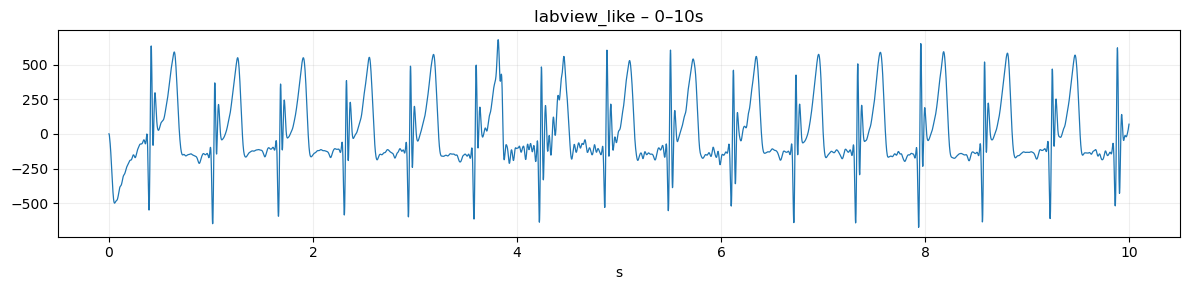

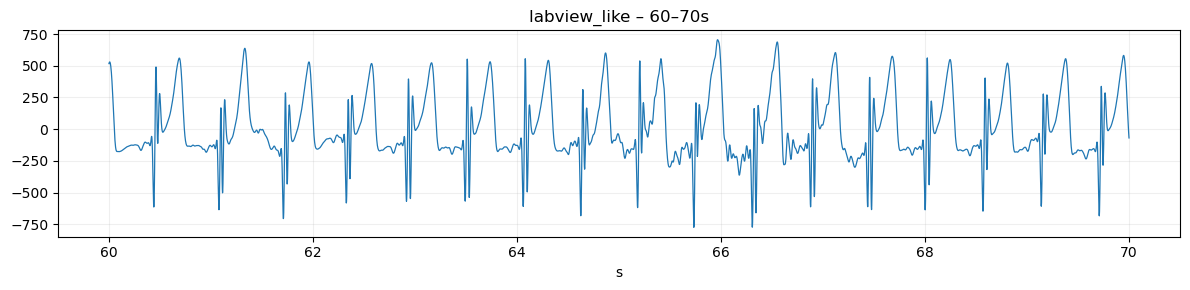

In [43]:
plot_zoom(y1, fs, t0=0,  dur=10, title="butter_clean – 0–10s")
plot_zoom(y1, fs, t0=60, dur=10, title="butter_clean – 60–70s")

plot_zoom(y2, fs, t0=0,  dur=10, title="labview_like – 0–10s")
plot_zoom(y2, fs, t0=60, dur=10, title="labview_like – 60–70s")


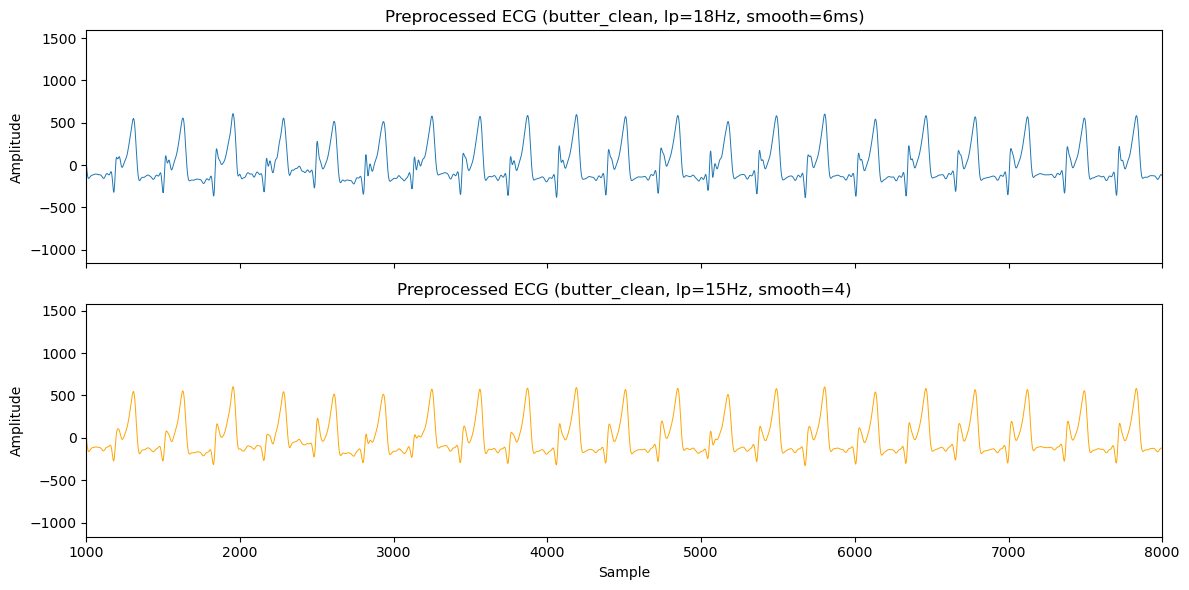

In [52]:
y1 = preproc_butter_clean(xw, fs, lp_fc=18.0, smooth_ms=6)
y2 = preproc_butter_clean(xw, fs, lp_fc=15.0, smooth_ms=4)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(y1, lw=0.7)
axs[0].set_title("Preprocessed ECG (butter_clean, lp=18Hz, smooth=6ms)")
axs[0].set_ylabel("Amplitude")
axs[0].set_xlim(1000, 8000)  # Zoom to samples 1000–8000

axs[1].plot(y2, lw=0.7, color='orange')
axs[1].set_title("Preprocessed ECG (butter_clean, lp=15Hz, smooth=4)")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Amplitude")
axs[1].set_xlim(1000, 8000)

plt.tight_layout()
plt.show()

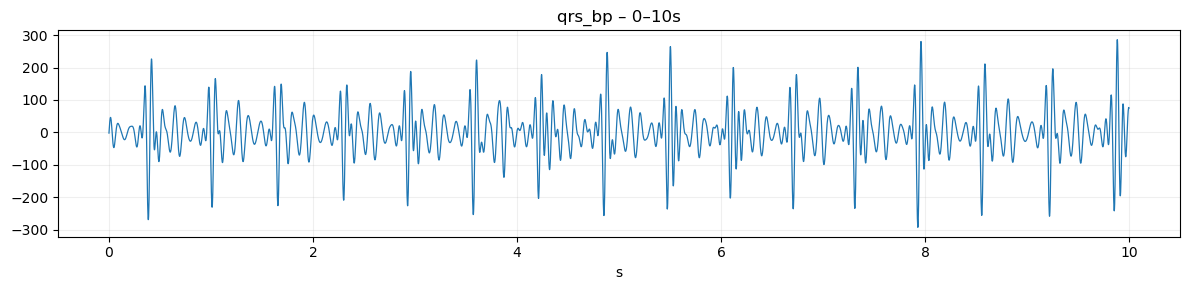

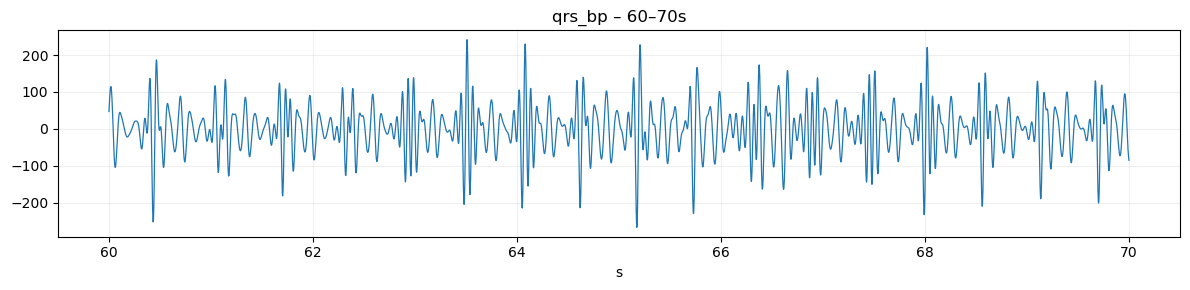

In [53]:
def preproc_qrs_bp(x, fs, hp=8.0, lp=20.0, smooth_ms=4):
    from scipy.signal import butter, sosfiltfilt, savgol_filter
    # 1) bandpass 8–20 Hz (QRS-bånd)
    sos = butter(4, [hp/(fs/2), lp/(fs/2)], btype="bandpass", output="sos")
    y = sosfiltfilt(sos, x)
    # 2) let smoothing for støj (ulige vindue, min 5)
    win = max(5, int(round(smooth_ms*1e-3*fs))//2*2+1)
    y = savgol_filter(y, window_length=win, polyorder=2, mode="interp")
    return y
y3 = preproc_qrs_bp(xw, fs, hp=8.0, lp=20.0, smooth_ms=4)
plot_zoom(y3, fs, t0=0, dur=10, title="qrs_bp – 0–10s")
plot_zoom(y3, fs, t0=60, dur=10, title="qrs_bp – 60–70s")

In [55]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

def qrs_enhance_pan_tompkins(x, fs, bp=(8.0, 20.0), integ_ms=40):
    # 1) bandpass 8–20 Hz
    sos = butter(4, [bp[0]/(fs/2), bp[1]/(fs/2)], btype="bandpass", output="sos")
    y = sosfiltfilt(sos, x)
    # 2) derivativ (1. ordens)
    d = np.diff(y, prepend=y[0])
    # 3) kvadrér
    s = d*d
    # 4) glidende integration (≈ energi over 40 ms)
    L = max(1, int(round((integ_ms/1000.0)*fs)))
    k = np.ones(L)/L
    z = np.convolve(s, k, mode="same")
    return z

def qrs_enhance_tkeo(x, fs, bp=(8.0, 20.0), integ_ms=30):
    # bandpass i QRS-båndet
    from scipy.signal import butter, sosfiltfilt
    sos = butter(4, [bp[0]/(fs/2), bp[1]/(fs/2)], btype="bandpass", output="sos")
    y = sosfiltfilt(sos, x)
    # TKEO: Ψ[x[n]] = x[n]^2 - x[n-1]*x[n+1]
    xn = y
    xp = np.roll(xn, 1); xm = np.roll(xn, -1)
    psi = xn*xn - xp*xm
    psi[0] = psi[-1] = 0.0
    # glidende integration 25–35 ms
    L = max(1, int(round((integ_ms/1000.0)*fs)))
    k = np.ones(L)/L
    z = np.convolve(np.maximum(psi, 0.0), k, mode="same")
    return z


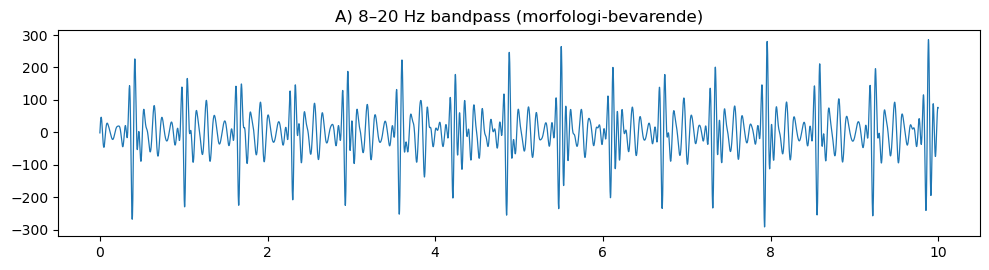

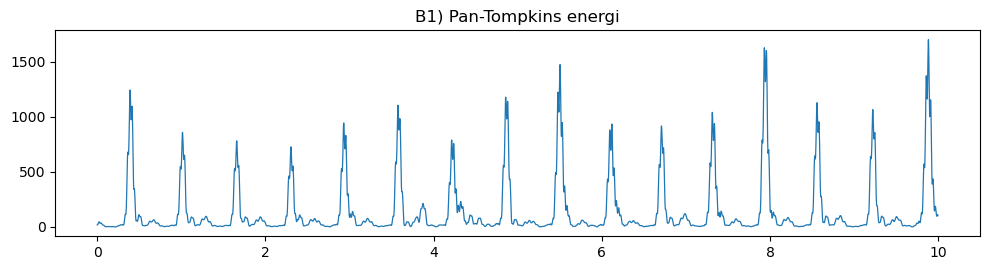

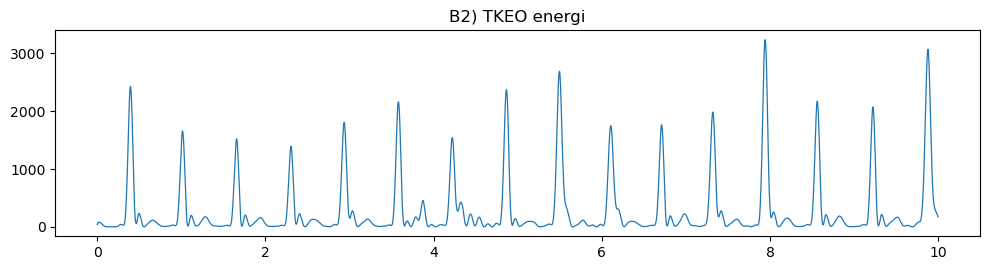

In [56]:
# xw, fs er dit udsnit
y_bp   = preproc_qrs_bp(xw, fs, hp=8, lp=20, smooth_ms=4)      # A: morfologi-bevarende
y_pan  = qrs_enhance_pan_tompkins(xw, fs, bp=(8,20), integ_ms=40) # B1: energi
y_tkeo = qrs_enhance_tkeo(xw, fs, bp=(8,20), integ_ms=30)         # B2: energi

# Plot 10 s
def zoom(sig, fs, t0=0, dur=10, title=""):
    i0, i1 = int(t0*fs), int((t0+dur)*fs)
    t = np.arange(i0,i1)/fs
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,2.8)); plt.plot(t, sig[i0:i1], lw=0.9); plt.title(title); plt.tight_layout(); plt.show()

zoom(y_bp,   fs, 0, 10, "A) 8–20 Hz bandpass (morfologi-bevarende)")
zoom(y_pan,  fs, 0, 10, "B1) Pan-Tompkins energi")
zoom(y_tkeo, fs, 0, 10, "B2) TKEO energi")


In [60]:
import numpy as np
from scipy.signal import iirnotch, filtfilt, remez, sosfiltfilt, butter

def _notch_series(x, fs, f0=50.0, n_harm=3, Q=35):
    y = x.copy()
    for k in range(1, n_harm+1):
        fk = f0*k
        if fk >= fs/2 - 0.5: break
        b,a = iirnotch(w0=fk/(fs/2), Q=Q)
        y = filtfilt(b,a,y)
    return y

def _fir_equiripple_highpass(fs, f_stop=0.5, f_pass=1.0, ripple_db=0.5, attn_db=60):
    """
    Parks–McClellan (Equi-Ripple) HP design to mimic LabVIEW ‘Equi Ripple highpass’.
    ripple_db ≈ passband ripple, attn_db ≈ stopband attenuation.
    We pick the order from transition width to hit ~attn_db.
    """
    nyq = fs/2.0
    # Normalize bands
    bands = [0, f_stop, f_pass, nyq]
    # Target gains: 0 in stop, 1 in pass
    desired = [0, 1]
    # Weights from ripple specs (approx)
    # passband ripple ~ ripple_db; stopband weight larger to reach attn_db
    w_stop = 10**(attn_db/20)   # heavier weight ⇒ deeper stop
    w_pass = 1.0 / max(1e-6, ripple_db)
    weights = [w_stop, w_pass]

    # Estimate order from transition width
    trans = max(1e-6, (f_pass - f_stop)/nyq)    # normalized
    # empirical: order ≈ 3/ trans; round to odd (linear‐phase HP)
    numtaps = int(np.ceil(3.0 / trans)) | 1
    numtaps = max(numtaps, 129)                 # keep reasonably sharp

    # Design and return taps
    taps = remez(numtaps,
                 bands=[0, f_stop, f_pass, nyq],
                 desired=desired,
                 weight=weights,
                 fs=fs)
    return taps

def _moving_average(x, win):
    if win <= 1: return x
    k = np.ones(win, dtype=float) / win
    return np.convolve(x, k, mode="same")

def preprocess_labview_like(
    x, fs,
    delete_start_s=0.0, delete_end_s=0.0,
    mains=50.0, mains_harm=3,
    hp_stop=0.5, hp_pass=1.0,          # Equi-Ripple HP (UI: stop freq / pass freq)
    smooth_half_at_512=4,              # VI: “half width 4 samples” → window = 2*4+1=9 @ 512 Hz
    add_lp32=False                     # set True only if your VI uses a 32 Hz lowpass
):
    # 0) delete edges (noise trimming like the VI controls)
    n0 = int(round(delete_start_s * fs))
    n1 = int(round(delete_end_s   * fs))
    if n0 + n1 >= len(x):
        raise ValueError("delete_start_s + delete_end_s removes entire signal.")
    y = x[n0: len(x) - (n1 if n1>0 else None)]

    # 1) mains notch
    y = _notch_series(y, fs, f0=mains, n_harm=mains_harm, Q=35)

    # 2) Equi-Ripple high-pass (Parks–McClellan) and zero-phase
    taps = _fir_equiripple_highpass(fs, f_stop=hp_stop, f_pass=hp_pass)
    y = filtfilt(taps, [1.0], y)  # linear‐phase FIR → filtfilt ok

    # 3) optional 32 Hz low-pass (rarely needed if smoothing used)
    if add_lp32:
        sos = butter(4, 32.0/(fs/2), btype="lowpass", output="sos")
        y = sosfiltfilt(sos, y)

    # 4) rectangular moving average with scaled half-width
    # scale half-width with fs so it matches “4 samples at 512 Hz”
    half = int(round(smooth_half_at_512 * (fs/512.0)))
    win = 2*half + 1
    if win > 1:
        y = _moving_average(y, win)

    return y, {"trimmed_samples": (n0, n1), "hp_taps": len(taps), "ma_win": win}


In [63]:
# 1) read TDMS
import importlib, jeppesen_pipeline as jp
jp = importlib.reload(jp)
x, t_sec, fs, *_ = jp.read_tdms_auto(TDMS_PATH, fs_override=512.0)

# 2) pick a test slice
START_S, DUR_S = 7*3600+38*60, 180.0
i0, i1 = int(START_S*fs), int((START_S+DUR_S)*fs)
xw = x[i0:i1]

# 3) LabVIEW-like preprocessing (match VI UI values)
yw, meta = preprocess_labview_like(
    xw, fs,
    delete_start_s=0.0, delete_end_s=0.0,   # set to what your VI shows (e.g. 60 / 300 s) if you trim BEFORE slicing
    mains=50.0, mains_harm=3,
    hp_stop=0.5, hp_pass=1.0,
    smooth_half_at_512=4,                   # “half width 4” in the screenshots
    add_lp32=False
)

# 4) plot quick zoom
import matplotlib.pyplot as plt, numpy as np
t = np.arange(len(yw))/fs
plt.figure(figsize=(10,3)); plt.plot(t, yw, lw=0.9); plt.title("LabVIEW-like preproc"); plt.xlabel("s"); plt.tight_layout(); plt.show()

# 5) feed the preprocessed signal into Jeppesen R-peak detector (unchanged)
lv = jp.LabVIEWRpeak(jp.LVParams(fs=fs))
peaks = lv.detect(yw)
plt.figure(figsize=(10,3)); plt.plot(t, yw, lw=0.8); plt.plot(peaks/fs, yw[peaks], "o"); plt.title("Preproc + R-peaks"); plt.tight_layout(); plt.show()


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

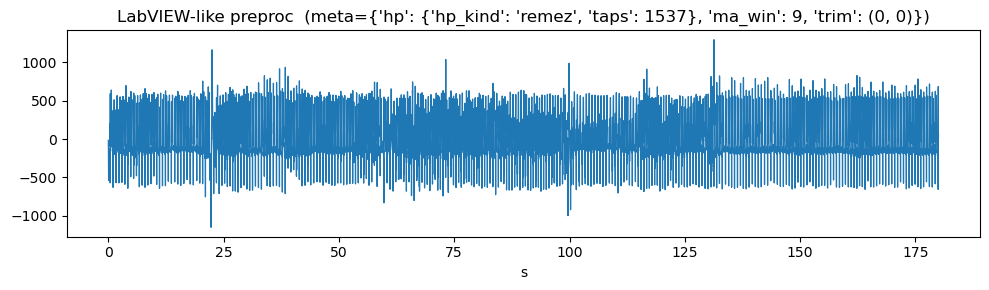

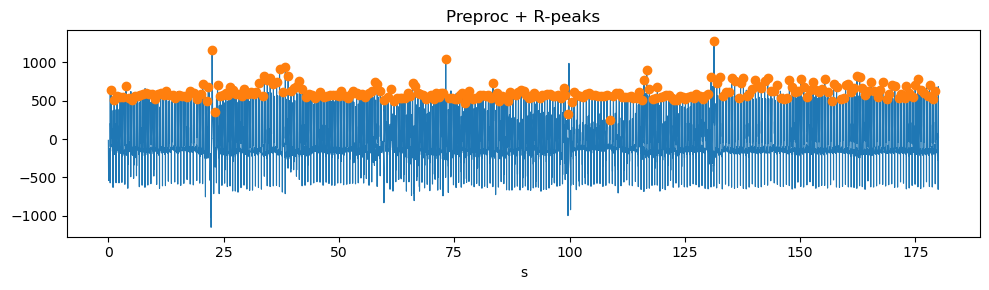

fs=512.0, peaks=290


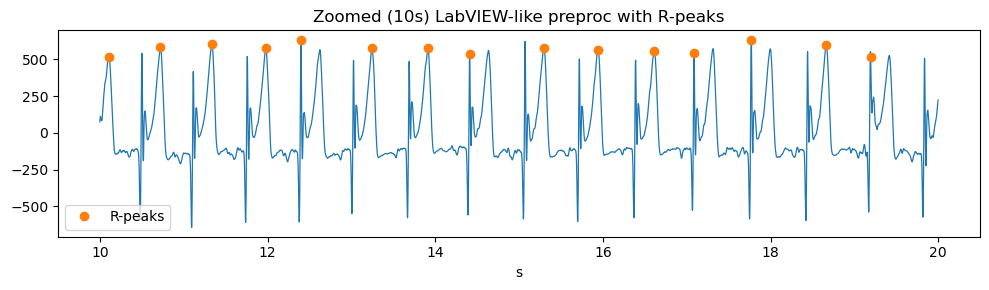

In [72]:
# --- robust LabVIEW-like preproc (inkl. fallback & kort-signal-guard) ---
import numpy as np
import importlib, jeppesen_pipeline as jp
jp = importlib.reload(jp)

from scipy.signal import iirnotch, filtfilt, butter, sosfiltfilt
try:
    from scipy.signal import remez as _remez_available
    _HAVE_REMEZ = True
except Exception:
    _HAVE_REMEZ = False

def _notch_series(x, fs, f0=50.0, n_harm=3, Q=35):
    y = np.asarray(x, float).ravel()
    for k in range(1, n_harm+1):
        fk = f0*k
        if fk >= fs/2 - 0.5: break
        b,a = iirnotch(w0=fk/(fs/2), Q=Q)
        y = filtfilt(b,a,y)
    return y

def _moving_average(x, win):
    if win <= 1: return x
    k = np.ones(int(win))/float(win)
    return np.convolve(x, k, mode="same")

def _fir_equiripple_highpass(x, fs, f_stop=0.5, f_pass=1.0):
    """Design and apply an Equi-Ripple HP if tilstrækkelig længde; ellers fallback."""
    y = np.asarray(x, float).ravel()
    if not _HAVE_REMEZ:
        # Fallback: 2. ordens Butter HP 1 Hz
        sos = butter(2, max(1e-3, f_pass)/(fs/2), btype="highpass", output="sos")
        return sosfiltfilt(sos, y), {"hp_kind":"butter_fallback","taps":None}
    # remez findes -> design
    from scipy.signal import remez
    nyq = fs/2.0
    trans = max(1e-6, (f_pass - f_stop)/nyq)    # normaliseret transition
    numtaps = int(np.ceil(3.0/trans)) | 1
    numtaps = int(np.clip(numtaps, 129, 2001)) # rimelig skarp, men begræns orden

    # Hvis signalet er for kort til filtfilt med denne FIR, så sænk orden
    # padlen ~ 3*(N-1); vi kræver len(y) > padlen
    def ok_len(nt): return len(y) > 3*(nt-1) + 1
    while numtaps > 63 and not ok_len(numtaps):
        numtaps -= 20
    if not ok_len(numtaps):
        sos = butter(2, max(1e-3, f_pass)/(fs/2), btype="highpass", output="sos")
        return sosfiltfilt(sos, y), {"hp_kind":"butter_fallback_short","taps":None}

    taps = remez(numtaps, [0, f_stop, f_pass, nyq], [0, 1], fs=fs)
    y = filtfilt(taps, [1.0], y)
    return y, {"hp_kind":"remez", "taps":numtaps}

def preprocess_labview_like(
    x, fs,
    delete_start_s=0.0, delete_end_s=0.0,
    mains=50.0, mains_harm=3,
    hp_stop=0.5, hp_pass=1.0,
    smooth_half_at_512=4,
    add_lp32=False
):
    y = np.asarray(x, float).ravel()

    # --- trim start/slut ---
    n0 = int(round(delete_start_s * fs))
    n1 = int(round(delete_end_s   * fs))
    if n0 + n1 >= len(y):
        raise ValueError("delete_start_s + delete_end_s fjerner hele signalet.")
    if n1 > 0:
        y = y[n0: len(y) - n1]
    else:
        y = y[n0:]

    # --- mains notch ---
    y = _notch_series(y, fs, f0=mains, n_harm=mains_harm, Q=35)

    # --- Equi-Ripple HP (eller fallback) ---
    y, hp_meta = _fir_equiripple_highpass(y, fs, f_stop=hp_stop, f_pass=hp_pass)

    # --- optional LP 32 Hz ---
    if add_lp32:
        sos = butter(4, 32.0/(fs/2), btype="lowpass", output="sos")
        y = sosfiltfilt(sos, y)

    # --- moving average (half width skaleret fra 4 @ 512 Hz) ---
    half = int(round(smooth_half_at_512 * (fs/512.0)))
    win = 2*max(1, half) + 1
    y = _moving_average(y, win)

    return y, {"hp":hp_meta, "ma_win":win, "trim":(n0,n1)}

# -------------------- din afvikling --------------------
# 1) TDMS

x, t_sec, fs, *_ = jp.read_tdms_auto(TDMS_PATH, fs_override=512.0)

# 2) Udsnit
START_S, DUR_S = 7*3600+38*60, 180.0
i0, i1 = int(START_S*fs), int((START_S+DUR_S)*fs)
xw = x[i0:i1]

# 3) Preproc (LabVIEW)
yw, meta = preprocess_labview_like(
    xw, fs,
    delete_start_s=0.0, delete_end_s=0.0,
    mains=50.0, mains_harm=3,
    hp_stop=0.5, hp_pass=1.0,
    smooth_half_at_512=4,
    add_lp32=False
)

# 4) Plot og R-peak detection
import matplotlib.pyplot as plt
t = np.arange(len(yw))/fs
plt.figure(figsize=(10,3)); plt.plot(t, yw, lw=0.9); plt.title(f"LabVIEW-like preproc  (meta={meta})"); plt.xlabel("s"); plt.tight_layout(); plt.show()

lv = jp.LabVIEWRpeak(jp.LVParams(fs=fs))
peaks = lv.detect(yw)
plt.figure(figsize=(10,3))
plt.plot(t, yw, lw=0.8)
plt.plot(peaks/fs, yw[peaks], "o")
plt.title("Preproc + R-peaks"); plt.xlabel("s")
plt.tight_layout(); plt.show()
print(f"fs={fs}, peaks={len(peaks)}")

# Zoomed plot: show 10 seconds with peak marks
zoom_start = 10  # seconds from start of window
zoom_dur = 10    # seconds to show

i_zoom0 = int(zoom_start * fs)
i_zoom1 = int((zoom_start + zoom_dur) * fs)

plt.figure(figsize=(10,3))
plt.plot(t[i_zoom0:i_zoom1], yw[i_zoom0:i_zoom1], lw=0.9)
# Mark peaks within zoomed region
peaks_in_zoom = peaks[(peaks >= i_zoom0) & (peaks < i_zoom1)]
plt.plot(t[peaks_in_zoom], yw[peaks_in_zoom], "o", label="R-peaks")
plt.title(f"Zoomed (10s) LabVIEW-like preproc with R-peaks")
plt.xlabel("s")
plt.legend()
plt.tight_layout()
plt.show()

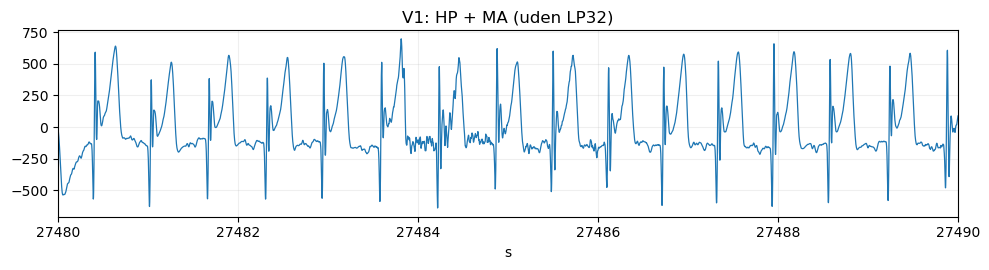

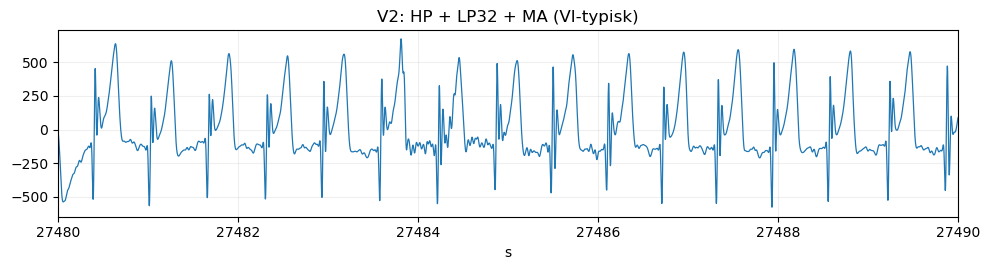

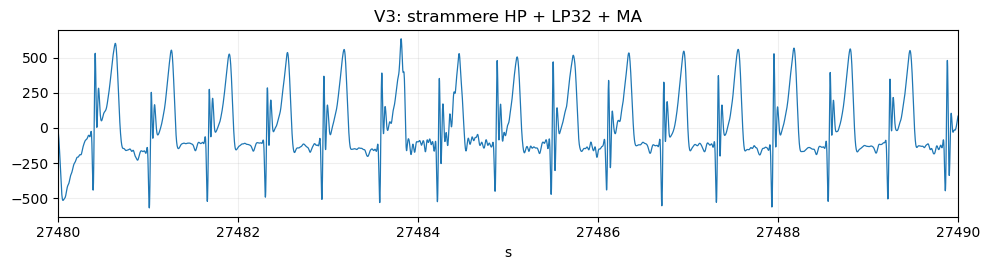

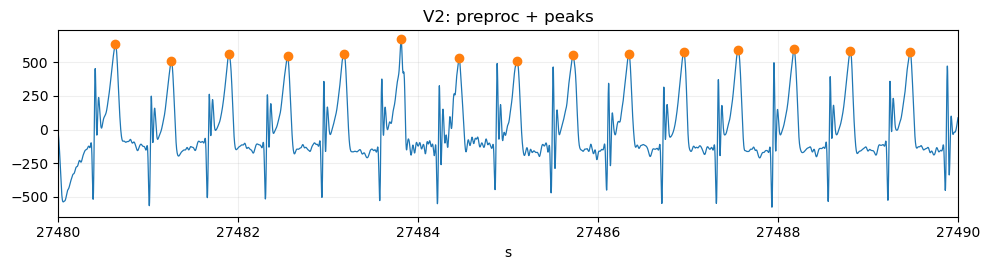

In [73]:
# --- A/B: hvordan dæmper vi T-takken mest VI-agtigt? ---
# antager preprocess_labview_like() fra før er i notebook'en
import numpy as np, matplotlib.pyplot as plt

# 1) udsnit (samme som før)
START_S, DUR_S = 7*3600+38*60, 20.0
i0, i1 = int(START_S*fs), int((START_S+DUR_S)*fs)
xw = x[i0:i1]
t  = np.arange(len(xw))/fs + START_S

# 2) tre varianter
y1,_ = preprocess_labview_like(xw, fs,
    mains=50.0, mains_harm=3,
    hp_stop=0.5, hp_pass=1.0,
    add_lp32=False,              # V1: uden LP32
    smooth_half_at_512=4)

y2,_ = preprocess_labview_like(xw, fs,
    mains=50.0, mains_harm=3,
    hp_stop=0.5, hp_pass=1.0,
    add_lp32=True,               # V2: med LP32 (typisk for VI)
    smooth_half_at_512=4)

y3,_ = preprocess_labview_like(xw, fs,
    mains=50.0, mains_harm=3,
    hp_stop=0.6, hp_pass=1.2,    # V3: lidt strammere HP
    add_lp32=True,
    smooth_half_at_512=4)

def zoomplot(y, title):
    plt.figure(figsize=(10,2.8))
    plt.plot(t, y, lw=0.9)
    plt.xlim(START_S, START_S+10)
    plt.title(title); plt.xlabel("s"); plt.grid(alpha=0.2)
    plt.tight_layout(); plt.show()

zoomplot(y1, "V1: HP + MA (uden LP32)")
zoomplot(y2, "V2: HP + LP32 + MA (VI-typisk)")
zoomplot(y3, "V3: strammere HP + LP32 + MA")

# Bonus: kør R-peak detektor på den variant der ligner VI bedst (fx V2)
import jeppesen_pipeline as jp
lv = jp.LabVIEWRpeak(jp.LVParams(fs=fs))
peaks = lv.detect(y2)
plt.figure(figsize=(10,2.8))
plt.plot(t, y2, lw=0.9); plt.plot((peaks/fs)+START_S, y2[peaks], "o")
plt.xlim(START_S, START_S+10)
plt.title("V2: preproc + peaks"); plt.xlabel("s"); plt.grid(alpha=0.2)
plt.tight_layout(); plt.show()


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def rt_ratio(y, fs):
    # grove peaks (uden at skelne R/T) – vi bruger kun til amplitude-statistik
    p,_ = find_peaks(y, distance=int(0.25*fs))  # >240 bpm guard
    if len(p) < 5: 
        return np.nan, p
    # naive skelnen: R er "højeste" i hver ca. 0.6 s; T ligger ~0.2–0.4 s efter R
    R = []
    T = []
    for i in range(len(p)-1):
        seg = y[p[i]:p[i+1]]
        if len(seg) == 0: continue
        rloc = np.argmax(seg); R.append(seg[rloc])
        # søg T i vindue 80–220 ms efter R (justér hvis dit signal er langsomt)
        t0 = p[i] + rloc + int(0.08*fs)
        t1 = p[i] + rloc + int(0.22*fs)
        if t1 < len(y) and t1>t0:
            tloc_rel = np.argmax(y[t0:t1])
            T.append(y[t0 + tloc_rel])
    if len(R)==0 or len(T)==0: return np.nan, p
    return (np.median(R)/np.median(T)), np.array(p)

def quick_rt_report(y, fs, label):
    ratio,_ = rt_ratio(y, fs)
    print(f"{label}: median R/T amplitude-ratio ≈ {ratio:.2f}")


In [75]:
quick_rt_report(y1, fs, "V1 HP+MA")
quick_rt_report(y2, fs, "V2 HP+LP32+MA")
quick_rt_report(y3, fs, "V3 strammere HP+LP32+MA")


V1 HP+MA: median R/T amplitude-ratio ≈ -5.53
V2 HP+LP32+MA: median R/T amplitude-ratio ≈ -4.85
V3 strammere HP+LP32+MA: median R/T amplitude-ratio ≈ -4.93


In [76]:
# A) Lidt højere HP (0.8/1.6 Hz) + LP32 + MA(half=3 @512)  ~ kortere glatning mindsker T-bredde
yA,_ = preprocess_labview_like(xw, fs, hp_stop=0.8, hp_pass=1.6, add_lp32=True, smooth_half_at_512=3)

# B) HP(0.6/1.2) + LP20 (mere aggressiv) + MA(half=4)
yB,_ = preprocess_labview_like(xw, fs, hp_stop=0.6, hp_pass=1.2, add_lp32=True, smooth_half_at_512=4)
#  -> ændr i preprocess-funktionen til LP 20 Hz ved add_lp32=True, hvis du vil prøve 20 Hz

# C) Decimer til 256 Hz før smoothing (matcher nogle VI-varianter i detektionsgrenen)
from scipy.signal import decimate
yHP,_ = preprocess_labview_like(xw, fs, hp_stop=0.5, hp_pass=1.0, add_lp32=True, smooth_half_at_512=4)
yC = decimate(yHP, 2, ftype='iir', zero_phase=True)   # fsC = 256
fsC = fs/2

# D) Kort MA + svag LP (24 Hz) – ofte god balance
# (skift LP32 → LP24 i preprocess midlertidigt og sæt smooth_half_at_512=3)
yD,_ = preprocess_labview_like(xw, fs, hp_stop=0.5, hp_pass=1.0, add_lp32=True, smooth_half_at_512=3)


A: median R/T amplitude-ratio ≈ -7.12


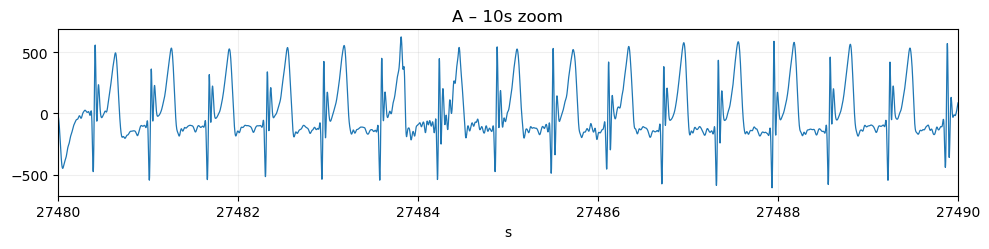

B: median R/T amplitude-ratio ≈ -4.93


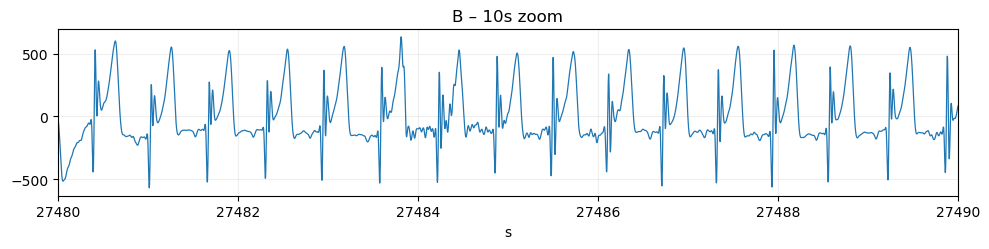

C: median R/T amplitude-ratio ≈ -4.84


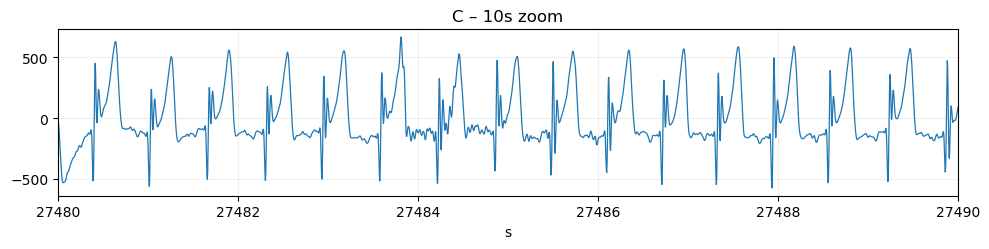

D: median R/T amplitude-ratio ≈ -5.12


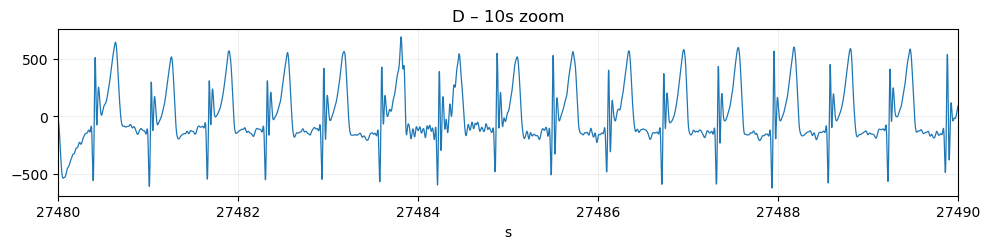

In [77]:
for lbl, yy, ffs in [("A",yA,fs),("B",yB,fs),("C",yC,fsC),("D",yD,fs)]:
    quick_rt_report(yy, ffs, lbl)
    t = np.arange(len(yy))/ffs + START_S
    plt.figure(figsize=(10,2.6))
    plt.plot(t, yy, lw=0.9); plt.xlim(START_S, START_S+10)
    plt.title(f"{lbl} – 10s zoom"); plt.xlabel("s"); plt.grid(alpha=0.2); plt.tight_layout(); plt.show()


In [ ]:
# Brug din ‘LabVIEWRpeak’ detektor
lv = jp.LabVIEWRpeak(jp.LVParams(fs=fs))
peaks = lv.detect(y2)   # tag fx V2

# visualisér Thigh/Tlow inde i et 10s udsnit
def debug_threshold_overlay(ecg, fs, detector, t0_s, dur_s=10.0):
    # simplificeret: brug de samme helpers som i pipelinen (måske hedder de anderledes hos dig)
    bp, thigh, tlow = detector._debug_series(ecg, fs)  # hvis du ikke har sådan en, kan jeg sende en lille helper
    i0, i1 = int(t0_s*fs), int((t0_s+dur_s)*fs)
    tt = np.arange(len(ecg))/fs
    plt.figure(figsize=(10,3))
    plt.plot(tt[i0:i1], bp[i0:i1], label="filtered")
    plt.plot(tt[i0:i1], thigh[i0:i1], '--', label="Thigh")
    plt.plot(tt[i0:i1], tlow[i0:i1],  '--', label="Tlow")
    pp = peaks[(peaks>=i0)&(peaks<i1)]
    plt.plot(tt[pp], bp[pp], 'o', label="peaks")
    plt.legend(); plt.title("Detektor overlay"); plt.xlabel("s"); plt.tight_layout(); plt.show()

# debug_threshold_overlay(y2, fs, lv, START_S)   # kør når _debug_series findes


AttributeError: 'LabVIEWRpeak' object has no attribute '_debug_series'